In [2]:
# import required modules
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

In [3]:
movie_path = "../data/raw/ml-latest-small/movies.csv"
rating_path = "../data/raw/ml-latest-small/ratings.csv"

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [4]:
def load_node_csv(path, index_col):
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    return mapping


user_mapping = load_node_csv(rating_path, index_col="userId")
movie_mapping = load_node_csv(movie_path, index_col="movieId")

In [5]:
def load_edge_csv(
    path,
    src_index_col,
    src_mapping,
    dst_index_col,
    dst_mapping,
    link_index_col,
    rating_threshold=4,
):
    df = pd.read_csv(path)
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = (
        torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long)
        >= rating_threshold
    )

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return torch.tensor(edge_index)


edge_index = load_edge_csv(
    rating_path,
    src_index_col="userId",
    src_mapping=user_mapping,
    dst_index_col="movieId",
    dst_mapping=movie_mapping,
    link_index_col="rating",
    rating_threshold=4,
)

In [6]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_users, num_movies = len(user_mapping), len(movie_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1
)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1
)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [7]:
train_sparse_edge_index = SparseTensor(
    row=train_edge_index[0],
    col=train_edge_index[1],
    sparse_sizes=(num_users + num_movies, num_users + num_movies),
)
val_sparse_edge_index = SparseTensor(
    row=val_edge_index[0],
    col=val_edge_index[1],
    sparse_sizes=(num_users + num_movies, num_users + num_movies),
)
test_sparse_edge_index = SparseTensor(
    row=test_edge_index[0],
    col=test_edge_index[1],
    sparse_sizes=(num_users + num_movies, num_users + num_movies),
)

# Sample Mini-batch


In [8]:
def sample_mini_batch(batch_size, edge_index):
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# LightGCN


In [9]:
# defines LightGCN model
class LightGCN(MessagePassing):
    def __init__(
        self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False
    ):
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim
        )  # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim
        )  # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        edge_index_norm = gcn_norm(edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])  # E^0
        embs = [emb_0]
        emb_k = emb_0

        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)  # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]
        )

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return (
            users_emb_final,
            self.users_emb.weight,
            items_emb_final,
            self.items_emb.weight,
        )

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x)


model = LightGCN(num_users, num_movies)

# Loss Function


In [10]:
def bpr_loss(
    users_emb_final,
    users_emb_0,
    pos_items_emb_final,
    pos_items_emb_0,
    neg_items_emb_final,
    neg_items_emb_0,
    lambda_val,
):
    reg_loss = lambda_val * (
        users_emb_0.norm(2).pow(2)
        + pos_items_emb_0.norm(2).pow(2)
        + neg_items_emb_0.norm(2).pow(2)
    )

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1)
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1)

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

# Metrics


In [11]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [12]:
def RP(groundTruth, r, k):
    num_correct_pred = torch.sum(r, dim=-1)
    user_num_liked = torch.Tensor(
        [len(groundTruth[i]) for i in range(len(groundTruth))]
    )
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [13]:
def NDCG(groundTruth, r, k):
    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1.0 / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1.0 / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.0] = 1.0
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.0
    return torch.mean(ndcg).item()

In [14]:
def get_metrics(model, edge_index, exclude_edge_indices, k):
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_positive_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        rating[exclude_users, exclude_items] = -(1 << 10)

    _, top_K_items = torch.topk(rating, k=k)
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype("float"))

    recall, precision = RP(test_user_pos_items_list, r, k)
    ndcg = NDCG(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [15]:
def evaluation(
    model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val
):
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index
    )
    edges = structured_negative_sampling(edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = (
        users_emb_final[user_indices],
        users_emb_0[user_indices],
    )
    pos_items_emb_final, pos_items_emb_0 = (
        items_emb_final[pos_item_indices],
        items_emb_0[pos_item_indices],
    )
    neg_items_emb_final, neg_items_emb_0 = (
        items_emb_final[neg_item_indices],
        items_emb_0[neg_item_indices],
    )

    loss = bpr_loss(
        users_emb_final,
        users_emb_0,
        pos_items_emb_final,
        pos_items_emb_0,
        neg_items_emb_final,
        neg_items_emb_0,
        lambda_val,
    ).item()

    recall, precision, ndcg = get_metrics(model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

# Training


In [16]:
# define contants
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [17]:
# setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cuda.


In [18]:
# training loop
train_losses = []
val_losses = []
recalls = []
precisions = []
ndcgs = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index
    )

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index
    )
    user_indices, pos_item_indices, neg_item_indices = (
        user_indices.to(device),
        pos_item_indices.to(device),
        neg_item_indices.to(device),
    )
    users_emb_final, users_emb_0 = (
        users_emb_final[user_indices],
        users_emb_0[user_indices],
    )
    pos_items_emb_final, pos_items_emb_0 = (
        items_emb_final[pos_item_indices],
        items_emb_0[pos_item_indices],
    )
    neg_items_emb_final, neg_items_emb_0 = (
        items_emb_final[neg_item_indices],
        items_emb_0[neg_item_indices],
    )

    # loss computation
    train_loss = bpr_loss(
        users_emb_final,
        users_emb_0,
        pos_items_emb_final,
        pos_items_emb_0,
        neg_items_emb_final,
        neg_items_emb_0,
        LAMBDA,
    )

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA
        )
        print(
            f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}"
        )
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        recalls.append(recall)
        precisions.append(precision)
        ndcgs.append(ndcg)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: -0.69132, val_loss: -0.68392, val_recall@20: 0.00136, val_precision@20: 0.00127, val_ndcg@20: 0.00129
[Iteration 200/10000] train_loss: -0.69872, val_loss: -0.68924, val_recall@20: 0.04131, val_precision@20: 0.01401, val_ndcg@20: 0.03007
[Iteration 400/10000] train_loss: -0.86734, val_loss: -0.82244, val_recall@20: 0.1391, val_precision@20: 0.04123, val_ndcg@20: 0.09682
[Iteration 600/10000] train_loss: -1.7827, val_loss: -1.51998, val_recall@20: 0.13915, val_precision@20: 0.04241, val_ndcg@20: 0.10123
[Iteration 800/10000] train_loss: -3.443, val_loss: -2.85833, val_recall@20: 0.14743, val_precision@20: 0.04503, val_ndcg@20: 0.10536
[Iteration 1000/10000] train_loss: -5.45768, val_loss: -4.49332, val_recall@20: 0.14939, val_precision@20: 0.04548, val_ndcg@20: 0.10576
[Iteration 1200/10000] train_loss: -7.21348, val_loss: -6.24178, val_recall@20: 0.1499, val_precision@20: 0.04494, val_ndcg@20: 0.1051
[Iteration 1400/10000] train_loss: -9.91621, val_loss:

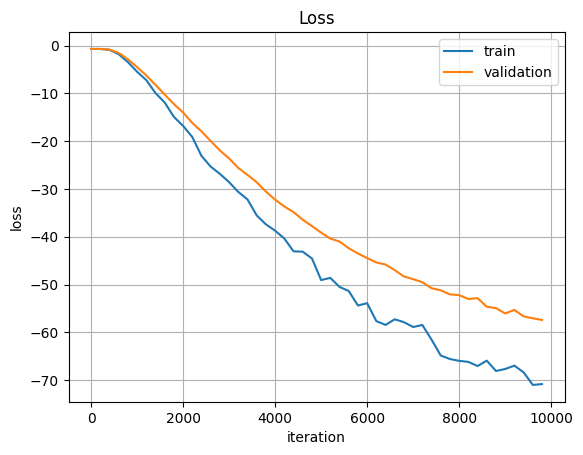

In [34]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label="train")
plt.plot(iters, val_losses, label="validation")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Loss")
plt.grid()
plt.legend()
plt.savefig("loss.png")

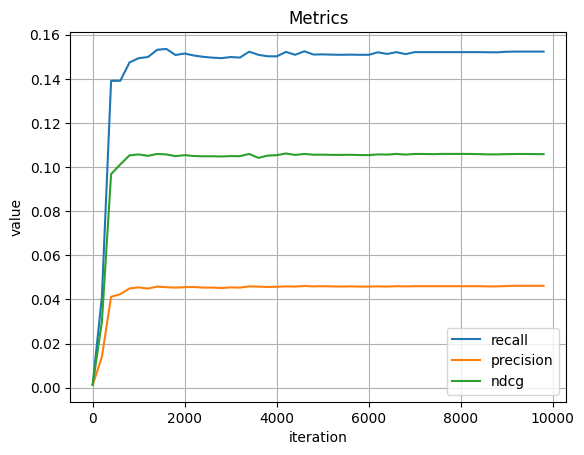

In [36]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(recalls))]
plt.plot(iters, recalls, label="recall")
plt.plot(iters, precisions, label="precision")
plt.plot(iters, ndcgs, label="ndcg")
plt.xlabel("iteration")
plt.ylabel("value")
plt.title("Metrics")
plt.grid()
plt.legend()
plt.savefig("metrics.png")

In [23]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
    model,
    test_edge_index,
    test_sparse_edge_index,
    [train_edge_index, val_edge_index],
    K,
    LAMBDA,
)

print(
    f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}"
)

[test_loss: -52.0814, test_recall@20: 0.12316, test_precision@20: 0.04647, test_ndcg@20: 0.09962


In [24]:
torch.save(model.state_dict(), "../models/checkpoint.pt")